# Graph-Optimizer Demo

## Tool description
In short, the Graph-Optimizer tool performs the following functions:
- Predicts the execution time (in milliseconds) and energy consumption (in Joules) for a given BGO or DAG of BGOs on a specific hardware configuration.
- Returns the model in symbolical form with graph properties as symbols or predicts execution times if the graph properties are specified.
- This is done via an API where issuing a POST request to `<api_url>/models` with the BGO DAG and hardware configuration returns an annotated DAG with calibrated symbolical models. Calling `<api_url>/evaluate` with the BGO DAG, hardware configuration, and graph properties returns an annotated DAG with predicted execution times.


### What is a BGO?
A BGO, or Basic Graph Operation, is an atomic graph operation, that can serve as a building block for constructing larger graph _workloads_.
A single BGO can have multiple implementations, possibly targeting different hardware platforms (e.g., CPU or GPU).
A workload is a Directed Acyclic Graph (DAG) of BGOs, where the nodes are BGOs and the edges represent data dependencies between them.
An example of such a DAG is shown below:

<img style="margin-bottom: -245px" src="dag.svg">

In this DAG, we start with the Betweenness Centrality (BC) BGO, followed by the Breadth First Search (BFS) and Find Max BGO's. Finally, we have the Find Path BGO to conclude. This example is a workload that outputs the path from the root node to the node with the highest betweenness centrality, which is the most popular node in the graph.

### Performance modeling

Each implementation of a BGO has a symbolic model that describes its execution time and energy consumption as functions of graph properties and hardware characteristics. Specifically, these hardware characteristics refer to the execution times of atomic operations in hardware, or operations considered to be atomic, such as reading a value from memory, writing a value to memory, performing an integer addition, and so on. These characteristics are obtained through _microbenchmarks_ run on the hardware where the BGO will be executed. The values obtained from the microbenchmarks are used to calibrate the symbolic models, which then provide the execution time and energy consumption of the BGO based solely on the graph properties. This approach allows for predicting the execution time and energy consumption of a BGO on a specific hardware configuration without needing to run the BGO on the hardware for any particular input graph.

Such a calibrated model might look like this:

$T_{BGO} = 561n \times 924m + 91n^2$,

where $n$ is the number of nodes in a graph, $m$ is the number of edges in the graph, and $T_{BGO}$ is the execution time of the BGO in milliseconds.

### Requirements

The following are the requirements to run this Graph-Optimizer demo.
You can either install them manually using the commands provided, or run the following code cell, which will install them automatically:
- **Flask**: The prediction server makes use of _Flask_ to serve the API. Install it using `pip install Flask`.
- **ipywidgets**: This notebook uses _ipywidgets_ for interactive experiments. Install it using `pip install ipywidgets`.

In [ ]:
# Install requirements
# Flask is required to run the prediction API
!pip install Flask
# Widgets are used later in this file for interacting with the data
!pip install ipywidgets
# Matplotlib is used for plotting
!pip install matplotlib

## Steps to use the Graph-Optimizer tool
### Step 1: Specify input DAG of BGO's

The first step in using Graph Optimizer is to specify the input DAG of BGO's. From the above list, select the BGO's you want to use and specify the input DAG.
This DAG should include one or multiple BGOs and their dependencies. The BGO name should match the name of the BGO folder in the `models` directory.
There are currently four BGO's available. These are:
- bc (Betweenness Centrality)
- bfs (Breadth First Search)
- find_max (Find Max)
- find_path (Find Path)

The dependencies should be specified as a list of BGO id's that the current BGO depends on. For instance, consider the following example with multiple BGOs and dependencies, representing the DAG shown in the introduction:

In [1]:
input_dag = [
    {
        "id": 0,
        "name": "bc",
        "dependencies": []
    },
    {
        "id": 1,
        "name": "find_max",
        "dependencies": [0]
    },
    {
        "id": 2,
        "name": "bfs",
        "dependencies": [0]
    },
    {
        "id": 3,
        "name": "find_path",
        "dependencies": [1,2]
    }
]

### Step 2: Specify hardware configuration
The hardware configuration aims to describe all available hardware components in a system or data center. The hardware information is used for the calibration of the performance models.

To specify the hardware configuration, you need to provide the configuration in JSON format. This configuration should list all unique available hosts in the data center, including details about CPUs and, if applicable, GPUs. Running microbenchmarks is part of this process and is done automatically with a script. An example configuration is provided below.

##### Alter the values in the hardware configuration to represent your own system. You can skip the microbenchmarks for now, as these will be done automatically later.

In [2]:
hardware = {
    "hosts": [
        {
            "id": 1,
            "name": "host1",
            "cpus": {
                "id": 1,
                "name": "intel xeon",
                "clock_speed": 2.10,
                "cores": 16,
                "threads": 32,
                "wattage": 250,
                "amount": 2,
                "benchmarks": {
                    "T_int_add": 2.4, "T_float_gt": 0.8,
                    "T_q_pop": 11.2, "T_q_push": 16.1, "T_q_front": 14.5,
                    "T_L1_read": 1.26, "T_L2_read": 4.24, "T_L3_read": 20.9, "T_DRAM_read": 62.5,
                    "L1_linesize": 64, "L2_linesize": 64, "L3_linesize": 64,
                    "T_heap_insert_max": 52.7, "T_heap_extract_min": 123.3, "T_heap_decrease_key": 12.7,
                    "T_push_back": 12
                }
            },
            "gpus": [
                {
                    "id": 1,
                    "name": "RTX 3080",
                    "clock_speed": 2.10,
                    "cores": 400,
                    "warps": 32,
                    "wattage": 100
                }
            ]
        }
    ]
}

#### Automated microbenchmarks

Running the following python cell will run the microbenchmarks on your machine (this should take a couple of seconds, probably no longer than a minute), and insert them into the hardware configuration.

The resulting values are the measured values for each operation in nanoseconds.

**Note**: for running the microbenchmarks, g++ is required.

In [3]:
from benchmarks.microbenchmarks import all_benchmarks
import json

# Run microbenchmarks on this machine
local_benchmarks = all_benchmarks()

# Pretty print the benchmarks
print(json.dumps(local_benchmarks, indent=4))

# Assign obtained values to the hardware description
hardware["hosts"][0]["cpus"]["benchmarks"] = local_benchmarks

Running microbenchmarks...
{
    "T_int_add": 0.3045941,
    "T_float_gt": 0.08016555,
    "T_q_push": 17.27074,
    "T_q_front": 13.5112,
    "T_q_pop": 11.48814,
    "T_heap_insert_max": 36.48801,
    "T_heap_extract_min": 145.6677,
    "T_heap_decrease_key": 10.88272,
    "T_push_back": 16.25789,
    "L1_linesize": 64,
    "L2_linesize": 64,
    "L3_linesize": 64,
    "T_L1_read": 1.3590503597556556,
    "T_L2_read": 4.500707122913199,
    "T_L3_read": 30.46357112881222,
    "T_DRAM_read": 69.0000929249403
}


### Step 3: Run the prediction server

The next step is running the prediction server, and getting the performance models for the input DAG for your specific hardware configurations.
This step can be divided into two subtasks. First we start the prediction server, and then we submit a POST request to the server to get the performance models.

1. Start the server using flask, by running the following command from the root directory:
    ```bash
    flask --app api/api.py run
    ```
    _(If you are using windows, use `python -m flask --app api/api.py run`)_

    This will start the server on `localhost:5000`. Use the following command to start the server on a different port:
    ```bash
    flask --app api/api.py run --port <port_number>
    ```
    You can either do this step, or run the python cell below, which will start the server for you.
    - **Note**: If you run the server via the cell below, make sure to wait for the server to start before proceeding to the next cells.
    - If you are finished with the experiments, you can stop the server by running the last cell in this document, which will terminate the server.
2. Run the prediction by submitting a POST request to the api
    - For obtaining the calibrated symbolical models, issue a post request to `localhost:<port_number>/models`, with the following post data:
        - "input_dag": The input BGO DAG in JSON format, as a string.
        - "hardware": The hardware configuration in JSON format, as a string.



In [4]:
# Start the server
import multiprocessing

port = 5000

def run_server():
    !flask --app api/api.py run --port {port}

server = multiprocessing.Process(target=run_server)
server.start()

/mnt/c/Users/BartD/Documents/PhD/shared_VM/graph-optimizer/models/prediction.py
 * Serving Flask app 'api/api.py'
 * Debug mode: off
 * Running on http://127.0.0.1:5000
Press CTRL+C to quit
127.0.0.1 - - [31/Jul/2024 08:55:39] "POST //models HTTP/1.1" 200 -
127.0.0.1 - - [31/Jul/2024 08:55:39] "POST //models HTTP/1.1" 200 -
127.0.0.1 - - [31/Jul/2024 08:55:42] "POST //models HTTP/1.1" 200 -
127.0.0.1 - - [31/Jul/2024 08:55:42] "POST //models HTTP/1.1" 200 -
127.0.0.1 - - [31/Jul/2024 08:55:46] "POST //models HTTP/1.1" 200 -
127.0.0.1 - - [31/Jul/2024 08:55:46] "POST //models HTTP/1.1" 200 -
127.0.0.1 - - [31/Jul/2024 08:55:46] "POST //models HTTP/1.1" 200 -
127.0.0.1 - - [31/Jul/2024 08:55:47] "POST //models HTTP/1.1" 200 -
127.0.0.1 - - [31/Jul/2024 08:55:47] "POST //models HTTP/1.1" 200 -
127.0.0.1 - - [31/Jul/2024 08:55:48] "POST //models HTTP/1.1" 200 -
127.0.0.1 - - [31/Jul/2024 08:55:48] "POST //models HTTP/1.1" 200 -
127.0.0.1 - - [31/Jul/2024 08:55:52] "POST //models HTTP/1.1" 

#### Interpreting the results

When submitting the post request to the API, the response will be the input DAG, but annotated with the calibrated symbolical models. The models will be in the form of a string representing a mathematical formula, with the graph properties as parameters.

For demonstration purposes, a dropdown and slider are provided below, which allow you to change the microbenchmarking parameters and see the impact they have on the performance models.

#### Submit a request to the prediction server by executing the cells below, and observe how the models change when altering the microbenchmarking parameters.

In [10]:
import requests
import json

url = f'http://localhost:{port}/'

def models_request():
    form_data = {
        'hardware': json.dumps(hardware),
        'bgo_dag': json.dumps(input_dag)
    }
    models_response = requests.post(url + '/models', data=form_data)
    return models_response.text

In [11]:
# Dropdown and slider functionality
from ipywidgets import interact, dlink, Dropdown, FloatSlider, Button
from IPython.display import Markdown, display, clear_output
from datetime import datetime
import os

clear_output()

microbenchmarks = hardware['hosts'][0]['cpus']['benchmarks']
microbenchmark_name = list(microbenchmarks.keys())[0]
dropdown = Dropdown(options=microbenchmarks.keys(), description='Variable')
slider = FloatSlider(min=0, max=200, step=0.01, description='Value', value=microbenchmarks[microbenchmark_name])
response = None


def save_config(arg):
    now = datetime.now().strftime('%Y-%m-%d.%H.%M.%S')
    dir_name = f'demo/saved_configs/{now}/'
    os.makedirs(dir_name, exist_ok=False)
    with open(f'{dir_name}/hardware.json', 'w') as hw_file:
        hw_file.write(json.dumps(hardware))
    with open(f'{dir_name}/models.json', 'w') as model_file:
        model_file.write(json.dumps(response))
    print(f'Configuration saved to {dir_name} directory')


def set_microbenchmark_name(variable):
    global microbenchmark_name
    microbenchmark_name = variable


def update_slider_value(x):
    global microbenchmark_name
    microbenchmark_name = x
    slider.value = microbenchmarks[x]
    return slider.value


def update_microbenchmark_value(value):
    global response
    hardware['hosts'][0]['cpus']['benchmarks'][microbenchmark_name] = value
    response = json.loads(models_request())
    return response


dlink((dropdown, 'value'), (slider, 'value'), update_slider_value)
display(Markdown('### Change the value of certain microbenchmarks, and see how they impact the performance models'))
save_button = Button(description='Save configuration')
save_button.on_click(save_config)
display(save_button)
interact(set_microbenchmark_name, variable=dropdown)
interact(update_microbenchmark_value, value=slider);


### Change the value of certain microbenchmarks, and see how they impact the performance models

Button(description='Save configuration', style=ButtonStyle())

interactive(children=(Dropdown(description='Variable', options=('T_int_add', 'T_float_gt', 'T_q_push', 'T_q_fr…

interactive(children=(FloatSlider(value=69.0, description='Value', max=200.0, step=0.01), Output()), _dom_clas…

### Step 4: Specify graph characteristics _(optional)_

The final step is to specify the graph characteristics of a specific graph for which you want to predict the execution time. This can be done by submitting a POST request to the API with the input DAG, hardware configuration, and graph properties. The API will return the input DAG annotated with the predicted execution times.

The graph properties are expressed in a simple JSON format of which an example is given below:

In [6]:
graph_props = {
    "n": 15763,
    "m": 171206,
    "average_degree": 21,
    "directed": False,
    "weighted": False,
    "diameter": 7,
    "clustering_coefficient": 0.0132526,
    "triangle_count": 591156,
    "s": 1000
}

In [7]:
def evaluate_request():
    form_data = {
        'hardware': json.dumps(hardware),
        'bgo_dag': json.dumps(input_dag),
        'graph_props': json.dumps(graph_props)
    }
    evaluate_response = requests.post(url + '/evaluate', data=form_data)
    print(evaluate_response.text)

def set_num_nodes(value):
    graph_props["n"] = value
    evaluate_request()

display(Markdown('### Change the number of nodes in the graph, and see how it impacts the performance and energy predictions'))
interact(set_num_nodes, value=FloatSlider(min=100, max=100000, step=1, description='#nodes', value=graph_props["n"]));

### Change the number of nodes in the graph, and see how it impacts the performance and energy predictions

interactive(children=(FloatSlider(value=15763.0, description='#nodes', max=100000.0, min=100.0, step=1.0), Out…

In [9]:
# Stop the server
server.terminate()

## Hardware configuration comparison


In [8]:
import os

saved_configs = 'demo/saved_configs'


responses = {}
for dir in os.listdir(saved_configs):
    path = os.path.join(saved_configs, dir)
    if not os.path.isdir(path):
        continue
    with open(os.path.join(path, 'hardware.json')) as f:
        hardware = f.read()
        form_data = {
            'hardware': hardware,
            'bgo_dag': json.dumps(input_dag),
            'graph_props': json.dumps(graph_props)
        }
        evaluate_response = requests.post(url + '/evaluate', data=form_data)
        responses[dir] = (json.loads(evaluate_response.text))


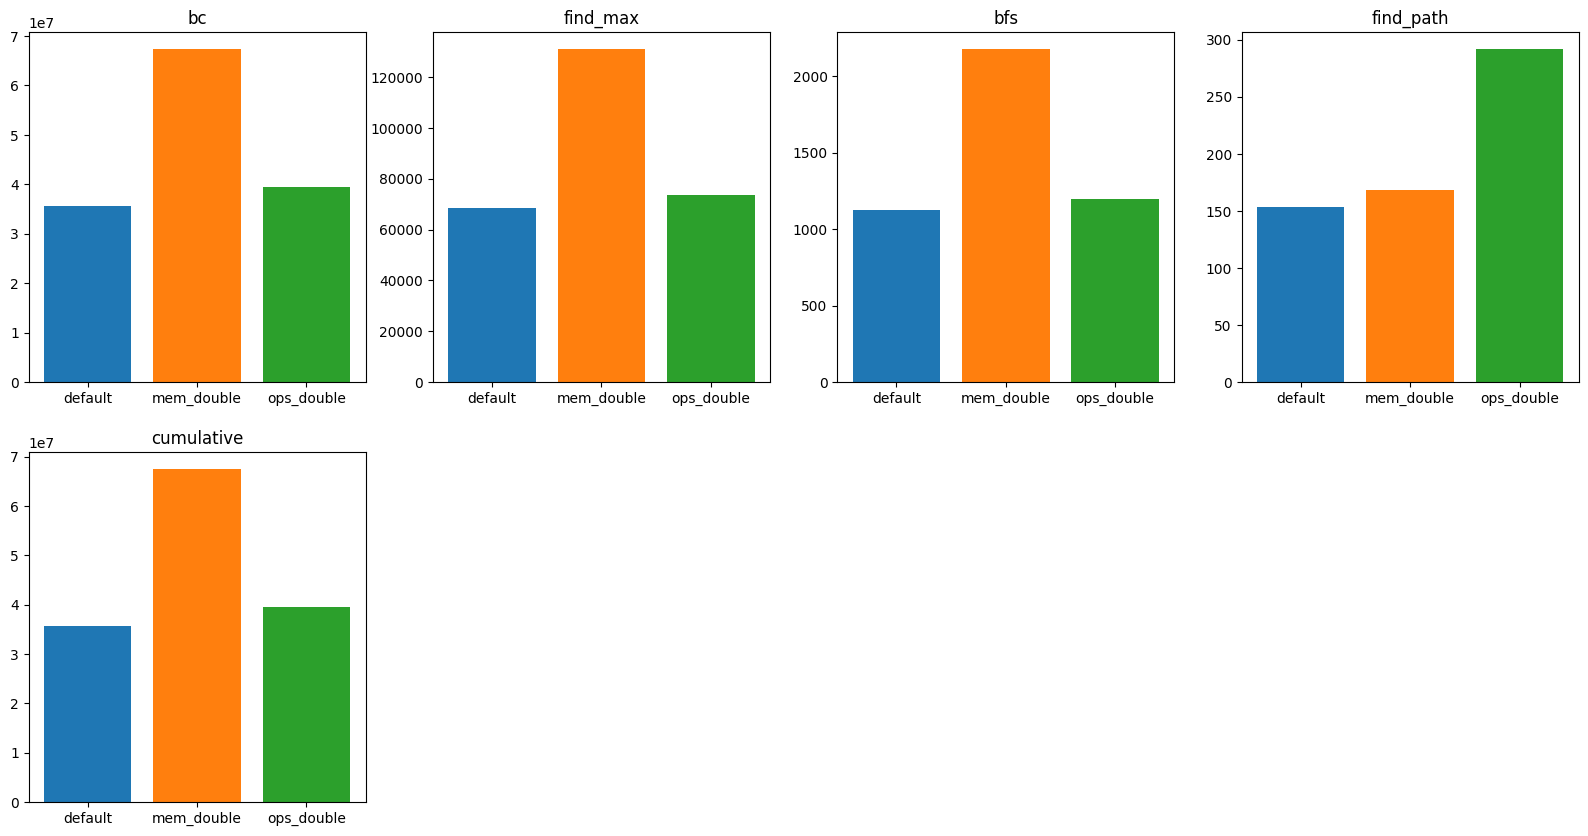

In [9]:
# Make a bar plot of the BGO's, for each BGO showing the different saved configurations as different bars
import matplotlib.pyplot as plt
from matplotlib.colors import TABLEAU_COLORS
import sys
import numpy as np
import math

def get_bgo_names(responses):
    # Get bgo names. Also assert if bgo's are the same for every hardware configuration
    bgo_names = None
    for dag in responses.values():
        new_bgo_names = [bgo['name'] for bgo in dag]

        assert bgo_names is None or new_bgo_names == bgo_names, 'BGO names are not the same for every hardware configuration'

        bgo_names = new_bgo_names

    return bgo_names


def get_runtime_per_bgo(annotated_dag):
    return [bgo['performances'][0]['runtime'] for bgo in annotated_dag]


bgo_names = get_bgo_names(responses)
bgo_names.append('cumulative')
all_values = {dir: get_runtime_per_bgo(dag) for dir, dag in responses.items()}
for key, value in all_values.items():
    all_values[key].append(sum(value))
all_colors = list(TABLEAU_COLORS.keys())

ncols = 4
nrows = math.ceil(len(bgo_names) / ncols)
fig, axs = plt.subplots(nrows, ncols, figsize=(20, 5*nrows))
axs_flat = axs.flat

for i, (ax, bgo) in enumerate(zip(axs_flat, bgo_names)):
    ax.set_title(bgo)
    names = all_values.keys()
    values = [v[i] for _, v in all_values.items()]
    bar_colors = [all_colors[i % len(all_colors)]for i in range(len(names))]
    ax.bar(names, values, color=bar_colors)

# remove unused plots
diff = len(axs_flat)-len(bgo_names)
if (diff > 0):
    for ax in axs_flat[-diff:]:
        ax.set_visible(False)

plt.show()